# CS Society Research Wing
## Tools For Research | Chapter 1: Web Scraping


### A Very Basic Intro to Python

In [5]:
A = "CS Society" # variables can contain strings
B = 100 # variables can also contain numbers

C = [100, 200, 300] # variables can also contain lists of values (values can be strings, numbers, other things also)

print(C[-3]) # you can use rectangular brackets to *index* into a list, indexing also works in reverse using negative values

print(A) # the print function can be used to print variables
print("Hello world") # or values directly

100
CS Society
Hello world


#### OOH ARE THOSE FUNCTIONS?
yes.

In [6]:
def sampleFunction(num): # use the def keyword to 'def'ine a function; a function can take an input (in brackets) or it can be without input also
    doubleNum = num * 2 # here we do some math
    return doubleNum # a function can return a value (or values) if it wants to, but not required

print(sampleFunction(10)) # this will double the number that you pass in the argument

20


### Okay, before we scrape, some imports

Python Programs can be packaged into modules/packages (the terminology is a bit hazy so forgive me), and we can import them and use them

| Package | Purpose |
| ----------- | ----------- |
| requests | Sends a request to a website, so the website sends back it's HTML source code in return |
| BeautifulSoup | Parses the HTML source code so that we can leverage the HTML tag organization and access the data in it |
| pandas | Let's us create table-like data structures so we can keep large amounts of scraped data organized |
| json | Helps us export data to .json files |
| tabulate, pprint | Prints data in nice pretty looking ways |

In [7]:
import requests # a standard import
from bs4 import BeautifulSoup # imports BeautifulSoup FROM the bs4 library

import pandas as pd # imports pandas, but gives it an ALIAS (pd). so now instead of typing out pandas to use it we can just type pd
import json # more standard imports

import tabulate 
import pprint

### A function to do some NLP stuff

NLP (Natural Language Processing) can do some pretty funky stuff with text, or more precisely, natural language text (stuff we say and write). In the function below we go through a list of reviews (of a book) and give them a polarity score using sentiment analysis. Feel free to mess around with it, but since this wasn't in the scope of a Web-Scraping Workshop, I didn't add comments. 

In [8]:
def performNLP(reviews):
    # Credits Neil Chowdhury for this function
    import nltk
    from nltk.sentiment import vader
    
    def regressionGraph(reviews):
        import seaborn as sns
        import matplotlib.pyplot as plt
        from sklearn.linear_model import LinearRegression
        import numpy as np
        
        sns.regplot(x = [ x['rating'] for x in reviews ], y = [ x['polarity'] for x in reviews ], line_kws={'color':'red'}).set_title('Polarity vs Rating')
        plt.show()
         
        x = np.array([ x['rating'] for x in reviews ]).reshape((-1, 1))
        y = np.array([ x['polarity'] for x in reviews ]).reshape((-1, 1))
        
        model = LinearRegression().fit(x, y).score(x, y)
        
        print("Regression Coefficient:", model)
        
    
    def polarityScore(reviews):
        sentimentIntensityAnalyzer = vader.SentimentIntensityAnalyzer()
        for review in reviews:
            review["polarity"] = (sentimentIntensityAnalyzer.polarity_scores(review["review"])['compound']+1)*(2)+1
        return reviews

    reviews = polarityScore(reviews)
    
    ratingList = [ review["rating"] for review in reviews ]
    polarityList = [ review["polarity"] for review in reviews ]
    
    averageRating = sum(ratingList)/len(ratingList)
    averagePolarity = sum(polarityList)/len(polarityList)
    
    print(tabulate.tabulate([[averageRating, averagePolarity]], headers=["Average Rating", "Average Polarity"]))
    
    regressionGraph(reviews)


### Another helper function to export our data

We want to store our data in files so we can access them later - this does that. 

In [9]:
def exportData(title, author, rating, desc, image, reviews):
    # export to json
    data = {
        "title": title,
        "author": author,
        "rating": rating,
        "desc": desc,
        "image": image
    }

    with open(f"{title.replace(':', '-').replace(' ', '-')}.json", "w+") as f:
        json.dump(data, f)

    # export image to title
    with open(title.replace(':', '-').replace(' ', '-') + ".jpg", "wb") as f:
        f.write(requests.get(image).content)
        
    # export reviews to csv    
    reviewsDF = pd.DataFrame(reviews)
    
    reviewsDF.to_csv(f"{title.replace(':', '-').replace('/', '-').replace(' ', '-')}.csv", index=False)

## The Scraper Code itself

There's comments throughout

In [10]:
def webScraper(url):
    # important, remember the .text at the end to avoid a parsing error
    pageText = requests.get(url).text
    
    # this requires correct version of bs4 to be installed if using apt-get, if using pip it's all good. html.parser is included
    soup = BeautifulSoup(pageText, 'html.parser')

    # id == id, class == class_, attrs == attrs={"name": "val"}
    # find only finds the FIRST instance of the query
    bookTitle = soup.find('h1', id='bookTitle').get_text().replace('  ', '').replace('\n', '')

    print(bookTitle)

    # find_all finds ALL instances of the query
    bookAuthors = soup.find_all('div', class_='authorName__container')

    bookAuthors_info = []

    # a for loop
    for bookAuthor in bookAuthors:
        authorName = bookAuthor.find('span').get_text()
        # find_parent finds the argument tag which is the parent. 
        # you can use .get to get some attribute
        authorLink = bookAuthor.find('span').find_parent("a").get("href")
        bookAuthors_info.append({"name": authorName, "link": authorLink})
    
    pprint.pprint(bookAuthors_info)

    # show nested tag example using reviews
    bookRating = float(soup.find('div', id='bookMeta').find('span', attrs={"itemprop": "ratingValue"}).get_text())

    print(bookRating)

    # show how this one has two, a shorter revealed one, and a longer hidden one. Also show how the id of the span 
    # might be different across different books, so we have to handle it recursively. Do a pprint or a tabulate to show the two elements
    bookDescription = soup.find('div', id='descriptionContainer').find('div', id='description').find_all('span')

    # pprint.pprint(bookDescription)

    # get the last span tag, get the text from it, and remove the whitespaces and text formatting tags. 
    bookDescription = bookDescription[-1].get_text().replace('<i>', ' ').replace('</i>', ' ').replace('\n', ' ').replace('  ', ' ')

    print(bookDescription)

    bookImage = soup.find('img', id='coverImage').get('src')

    print(bookImage)
    
    # finds all the review blocks
    bookReviewBlocks = soup.find_all('div', class_='friendReviews')

    # initializes empty list    
    bookReviews = list()

    for bookReviewBlock in bookReviewBlocks:
        # get the title of the review
        reviewAuthor = bookReviewBlock.find('a', class_='imgcol').get('title').replace('  ', '').replace('\n', '')
    
        # review text was obtained by finding the two spans, one which reveals on reveal.     
        reviewText = bookReviewBlock.find('div', class_='bodycol').find('span', class_='readable').find_all('span')[-1].get_text().replace('<i>', ' ').replace('</i>', ' ').replace('\n', ' ').replace('  ', ' ')
        
        # rating is obtained by counting the number of p10 objects, which contain the full stars
        reviewRating = len(bookReviewBlock.find('div', class_='bodycol').find('div', class_='reviewHeader').find_all('span', class_='p10'))
        
        # append the reviews to the list
        bookReviews.append({"author": reviewAuthor, "review": reviewText, "rating": reviewRating})


    # ooooh what even is NLP?
    performNLP(bookReviews)

    exportData(bookTitle, bookAuthors_info, bookRating, bookDescription, bookImage, bookReviews)

## Run the code!

Dune
[{'link': 'https://www.goodreads.com/author/show/58.Frank_Herbert',
  'name': 'Frank Herbert'}]
4.24
Set on the desert planet Arrakis, Dune is the story of the boy Paul Atreides, heir to a noble family tasked with ruling an inhospitable world where the only thing of value is the “spice” melange, a drug capable of extending life and enhancing consciousness. Coveted across the known universe, melange is a prize worth killing for...When House Atreides is betrayed, the destruction of Paul’s family will set the boy on a journey toward a destiny greater than he could ever have imagined. And as he evolves into the mysterious man known as Muad’Dib, he will bring to fruition humankind’s most ancient and unattainable dream.
https://i.gr-assets.com/images/S/compressed.photo.goodreads.com/books/1555447414l/44767458.jpg
  Average Rating    Average Polarity
----------------  ------------------
         3.76667             3.97327


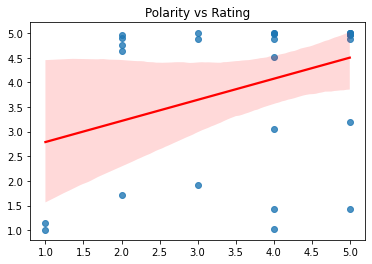

Regression Coefficient: 0.13763606609988444


In [11]:
webScraper("https://www.goodreads.com/book/show/44767458-dune")